In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [3]:
run = 46
probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [4]:
start = 120000# 30000
stop = 160000
by = 1

In [5]:
@utils.no_kwargs
@utils.dict_apply
def seriesToFloat(s):
    return s.values[0]

## Flux Probes

In [6]:
qoisOutputed = [
    "mass_flux",
    "mass_flux(p)",
    "mass_flux(T)",
    "mass_flux(D)",
    "mass_flux(S)",
    "sn_prod(u)",
    "sn_prod(p)",
    "sn_prod(abs(u))",
    "sn_prod(u**2)"
]
qois= ["mass_flux"]

# probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed)
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")

processing data took 1 seconds
processing data took 1 seconds


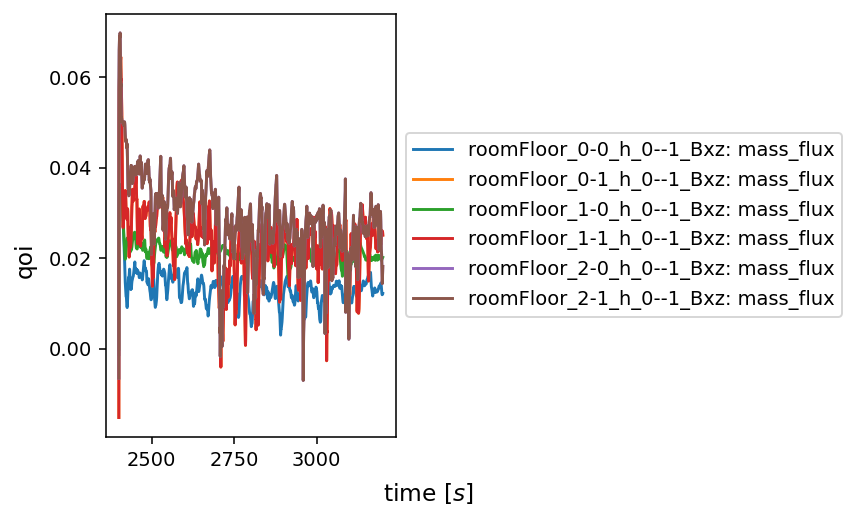

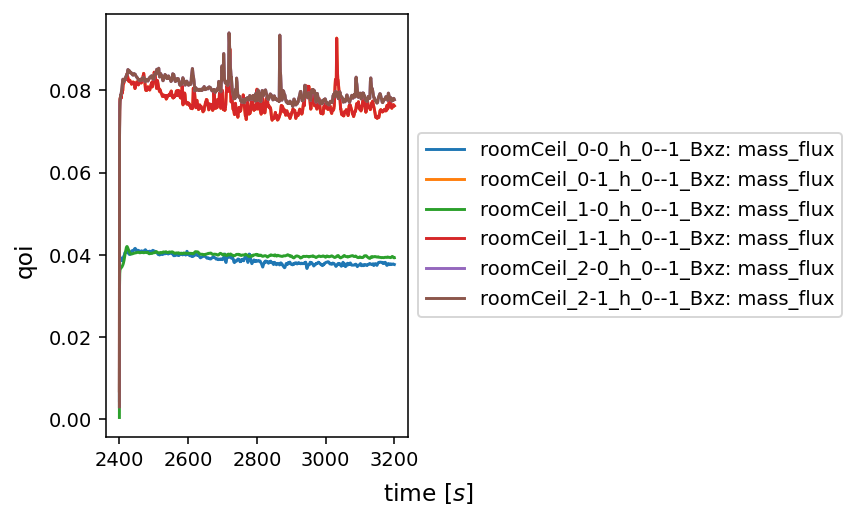

In [7]:
names = probes.probe_names
names = [name for name in  names if "_h_0--1_Bxz" in name]
names = [name for name in  names if "Floor" in name]

(fig, ax) = probes.time_plots(
    names = names, 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'qoi',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        'plot every': 1000
        },
    processing = [],
    parrallel=True
    )


names = probes.probe_names
names = [name for name in  names if "_h_0--1_Bxz" in name]
names = [name for name in  names if "Ceil" in name]

(fig, ax) = probes.time_plots(
    names = names, 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'qoi',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        'plot every': 1000
        },
    processing = [],
    parrallel=True
    )

In [22]:


## mean statistics
mean = probes.statistics(
    names = [name for name in  probes.probe_names if "Floor" in name or "Ceil" in name],
    steps = probes.probe_steps[start:stop:by],
    processing = [probePost.time_average, seriesToFloat],
    parrallel=False
    )
    
## rms statistics
rms = probes.statistics(
    names = [name for name in  probes.probe_names if "Floor" in name or "Ceil" in name], 
    steps = probes.probe_steps[start:stop:by],
    processing = [probePost.time_rms, seriesToFloat],
    parrallel=False
    )

processing data took 8 seconds
processing data took 8 seconds


In [ ]:
roomFluxMean = pd.read_csv(f"{oak_probes_dir}/../roomFluxMean-40000to120000.csv", index_col=0)


# Function to extract components from the string
def parseRoomFluxIndex(string):
    parts = string.split('_')
    parts = [p for p in parts if p != 'h']
    prefix = parts[0]  # roomCeil or roomFloor
    room = parts[1]  # 0-0, 2-1, etc.
    house = parts[2]  # h_0--2, h_0-2, etc.
    block = parts[3] if len(parts) > 3 else ''  # Bx, Bz, Bxz, or ''

    # Extract flux_type (ceil or floor) from prefix
    flux_type = 'ceil' if 'Ceil' in prefix else 'floor'

    return pd.Series([flux_type, room, house, block])

# Apply the parsing function to the dataframe and assign column names
roomFluxMean[['fluxType', 'roomType', 'houseType', 'blockType']] = roomFluxMean.index.to_series().apply(parseRoomFluxIndex)
roomFluxMean = roomFluxMean[~roomFluxMean['roomType'].isin(['0-1', '2-1'])]

g = sns.FacetGrid(roomFluxMean, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mass_flux(S)", "roomType", "fluxType", palette = "tab10", size = 4)
g.add_legend()

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomFluxMean['x'], roomFluxMean['z'], s=4*im_scaling, c=roomFluxMean["area"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)